In [1]:
%matplotlib inline
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from Tree import Tree, Node

import sys  
sys.path.insert(0, '../notebooks/')
from utils import calc_cost, plot_kmeans, plot_tree_boundary

/Users/lucasmurtinho/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass centers=8, cluster_std=2.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


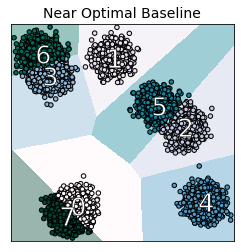

In [2]:
n = 10000
d = 2
k = 8
x_data, _ = make_blobs(n, d, k, 2.5, random_state=42, center_box=[-30,30])

kmeans = KMeans(k, random_state=42)
kmeans.fit(x_data)

plot_kmeans(kmeans, x_data)

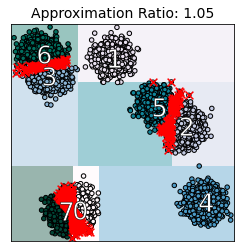

In [3]:
tree_1k = Tree(k)
tree_1k.fit(x_data, kmeans)

plot_tree_boundary(tree_1k, k, x_data, kmeans, plot_mistakes=True)

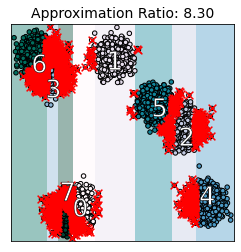

In [4]:
tree_0d = Tree(k, valid_col_idx=[0])
tree_0d.fit(x_data, kmeans)

plot_tree_boundary(tree_0d, k, x_data, kmeans, plot_mistakes=True)

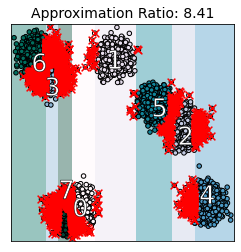

In [5]:
tree_c0 = Tree(k, valid_col_idx=[0])
tree_c0.get_tree_1d(x_data,kmeans)
plot_tree_boundary(tree_c0, k, x_data, kmeans, plot_mistakes=True)

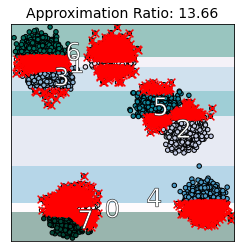

In [6]:
tree_1d = Tree(k, valid_col_idx=[1])
tree_1d.fit(x_data, kmeans)

plot_tree_boundary(tree_1d, k, x_data, kmeans, plot_mistakes=True)

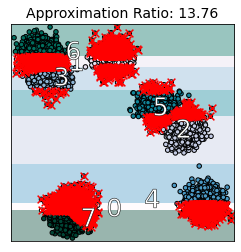

In [7]:
tree_c1 = Tree(k, valid_col_idx=[1])
tree_c1.get_tree_1d(x_data,kmeans)
plot_tree_boundary(tree_c1, k, x_data, kmeans, plot_mistakes=True)

In [8]:
tree_c = Tree(k)
tree_c.build_1d_trees(x_data,kmeans)
# plot_tree_boundary(tree_c1, k, x_data, kmeans, plot_mistakes=True)

In [9]:
def print_tree(tree):
    nodes = [(-1, tree)]
    i = 0
    while nodes:
        parent, node = nodes.pop(0)
        print(i, parent, node.feature, node.value)
        if node.left:
            nodes.append((i, node.left))
        if node.right:
            nodes.append((i, node.right))
        i += 1

In [10]:
print_tree(tree_c.trees_1d[0])

0 -1 0 -0.7444542806146077
1 0 0 -12.858643398103407
2 0 0 9.945035110480044
3 1 0 -23.90541494287015
4 1 None 1
5 2 None 5
6 2 0 16.89148025929387
7 3 0 -27.513029003712326
8 3 0 -19.829684349303996
9 6 None 2
10 6 None 4
11 7 None 6
12 7 None 3
13 8 None 7
14 8 None 0


In [11]:
print_tree(tree_c.trees_1d[1])

0 -1 1 -5.65887256709264
1 0 1 -19.809414581880695
2 0 1 17.091171796139985
3 1 None 7
4 1 1 -17.703645092637345
5 2 1 9.153485241293525
6 2 1 24.435648750578704
7 4 None 0
8 4 None 4
9 5 None 2
10 5 None 5
11 6 None 3
12 6 1 27.706388555470674
13 12 None 1
14 12 None 6


In [12]:
tree_1 = tree_c.tree_1d_cost_search(x_data,kmeans,1)
print_tree(tree_1)

0 -1 1 -5.65887256709264
1 0 1 -19.809414581880695
2 0 1 17.091171796139985
3 1 None 7
4 1 1 -17.703645092637345
5 2 1 9.153485241293525
6 2 1 24.435648750578704
7 4 None 0
8 4 None 4
9 5 None 2
10 5 None 5
11 6 None 3
12 6 1 27.706388555470674
13 12 None 1
14 12 None 6


In [ ]:
print_tree(tree_c1.tree)

In [13]:
dim = 1

if hasattr(kmeans,'labels_'):
    y = np.array(kmeans.labels_, dtype=np.int32)
else:
    y = np.array(kmeans.predict(x_data), dtype=np.int32)

centers = kmeans.cluster_centers_
idx_centers = centers[:,dim].argsort()
centers_d   = centers[:,dim][idx_centers]
assigns_d   = centers[y,dim]
x_d         =  x_data[:,dim]

In [14]:
centers, idx_centers, centers_d, assigns_d.shape, x_d.shape

(array([[-18.21696194, -18.27339646],
        [ -7.50032486,  27.1797758 ],
        [ 13.87865393,   5.81614859],
        [-26.36842313,  21.6915217 ],
        [ 19.90430659, -17.13389373],
        [  6.01141629,  12.49082189],
        [-28.65763488,  28.23300131],
        [-21.44240676, -21.34543271]]),
 array([7, 0, 4, 2, 5, 3, 1, 6]),
 array([-21.34543271, -18.27339646, -17.13389373,   5.81614859,
         12.49082189,  21.6915217 ,  27.1797758 ,  28.23300131]),
 (10000,),
 (10000,))

In [15]:
def find_first_above(val, seq):
    if not len(seq):
        return 0
    elif len(seq) == 1:
        return int(val >= seq[0])
    mid = len(seq) // 2
    if seq[mid] > val:
        return find_first_above(val, seq[:mid])
    else:
        return mid + 1 + find_first_above(val, seq[mid+1:])

In [16]:
# get separations
mids = (centers_d[1:] + centers_d[:-1]) / 2
# print(centers, mids)
above_d = np.array([find_first_above(d, mids) for d in x_d])
above_c_dict = {c: find_first_above(c, mids) for c in centers_d}
above_c = np.array([above_c_dict[a] for a in assigns_d])
separated = np.array([[int( (i >= min(j)) and (i < max(j)) )
                     for i in range(len(mids))]
                    for j in zip(above_d, above_c)])

In [17]:
costs = separated.sum(axis=0)
costs

array([ 824, 1014,    0,  204,   55,  312, 1083])

In [18]:
min_costs = costs.min()
cut = costs.argmin()
cut

2